In [2]:
import psycopg2
import pandas as pd

In [3]:
conn = psycopg2.connect(
    host="localhost", port="5432", database="project_analytics", user="postgres", password="}Brindavanam6"
)

In [4]:
query = "select * from projects;"
df = pd.read_sql_query(query, conn)
print(df.head())

                project_name  \
0                 Rhinestone   
1     A Triumph Of Softwares   
2              The Blue Bird   
3  Remembering Our Ancestors   
4                   Skyhawks   

                                 project_description  \
0  Associations Now Is A Casual Game To Teach You...   
1  Is A Fully Managed Content Marketing Software ...   
2  Most Content Marketers Know The Golden Rule: Y...   
3  Utilize And Utilizes (Verb Form) The Open, Inc...   
4  Is A Solution For Founders Who Want To Win At ...   

                  project_type  project_manager region           department  \
0            INCOME GENERATION      Yael Wilcox  North           Admin & BI   
1            INCOME GENERATION  Brenda Chandler   West            eCommerce   
2            INCOME GENERATION    Nyasia Hunter  North            Warehouse   
3          PROCESS IMPROVEMENT  Brenda Chandler   East  Sales and Marketing   
4  WORKING CAPITAL IMPROVEMENT  Jaylyn Mckenzie   East            eCommerce

C:\Users\raman\AppData\Local\Temp\ipykernel_24984\1088696984.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [5]:
print(df.info())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   project_name         99 non-null     object        
 1   project_description  99 non-null     object        
 2   project_type         99 non-null     object        
 3   project_manager      99 non-null     object        
 4   region               99 non-null     object        
 5   department           99 non-null     object        
 6   project_cost         99 non-null     float64       
 7   project_benefit      99 non-null     float64       
 8   complexity           99 non-null     object        
 9   status               99 non-null     object        
 10  completionpercent    99 non-null     float64       
 11  phase                99 non-null     object        
 12  year                 99 non-null     int64         
 13  month                99 non-null     

In [6]:
# Convert dates
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

# Duration in days
df['actual_duration_days'] = (df['end_date'] - df['start_date']).dt.days

# Example expected duration (can be average per project_type)
expected_duration = df.groupby('project_type')['actual_duration_days'].transform('mean')
df['delay_days'] = df['actual_duration_days'] - expected_duration
df['is_delayed'] = df['delay_days'] > 0

# Completion speed
df['completion_speed'] = df['completionpercent'] / df['actual_duration_days']

# Cost efficiency
df['cost_efficiency'] = df['project_benefit'] / df['project_cost']

# Tasks per month (optional bottleneck proxy)
df['tasks_per_month'] = df['completionpercent'] / (df['actual_duration_days'] / 30)
threshold = df['tasks_per_month'].quantile(0.9)
df['resource_bottleneck'] = df['tasks_per_month'] > threshold


In [7]:
# Features (numerical + categorical)
features = ['project_cost', 'project_benefit', 'complexity', 'completionpercent', 
            'actual_duration_days', 'completion_speed', 'cost_efficiency']

# Include categorical columns
categorical_cols = ['project_type', 'project_manager', 'region', 'department', 'phase', 'status']
df_encoded = pd.get_dummies(df[features + categorical_cols], drop_first=True)

X = df_encoded
y_delay = df['delay_days']
y_bottleneck = df['resource_bottleneck']


In [12]:
#RandomForest for Delay Prediction
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import joblib

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_delay, test_size=0.2, random_state=42)

# Model
rf_delay = RandomForestRegressor(n_estimators=100, random_state=42)
rf_delay.fit(X_train, y_train)

y_pred = rf_delay.predict(X_test)
print("MAE for delay prediction:", mean_absolute_error(y_test, y_pred))

# Save model
joblib.dump(rf_delay, "rf_delay_model.pkl")


MAE for delay prediction: 0.18318350168350334


['rf_delay_model.pkl']

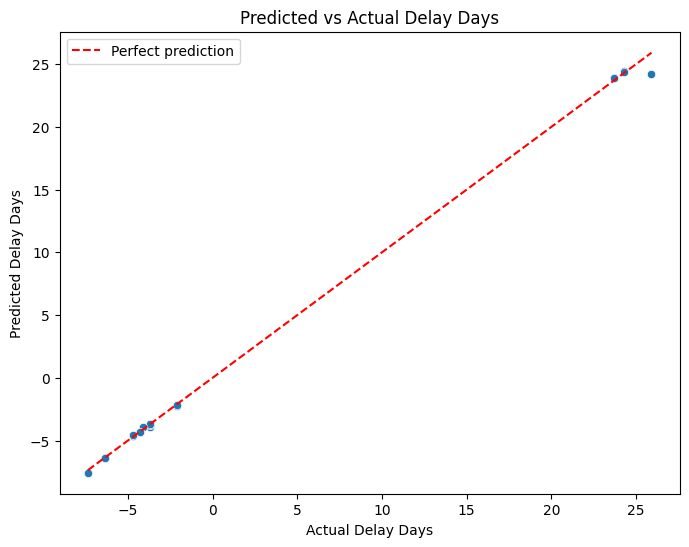

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Difference between predicted and actual
errors = y_test - y_pred

# 1. Scatter plot: predicted vs actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect prediction')
plt.xlabel('Actual Delay Days')
plt.ylabel('Predicted Delay Days')
plt.title('Predicted vs Actual Delay Days')
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print("R² score:", r2)


R² score: 0.9988508330664374


In [10]:
#RandomForestClassifier for Bottleneck Prediction
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y_bottleneck, test_size=0.2, random_state=42)

rf_bottleneck = RandomForestClassifier(n_estimators=100, random_state=42)
rf_bottleneck.fit(X_train, y_train)

y_pred = rf_bottleneck.predict(X_test)
print("Accuracy for bottleneck prediction:", accuracy_score(y_test, y_pred))

joblib.dump(rf_bottleneck, "rf_bottleneck_model.pkl")


Accuracy for bottleneck prediction: 1.0


['rf_bottleneck_model.pkl']